In [1]:
import warnings
warnings.filterwarnings('ignore')

In [427]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import pandas as pd
import seaborn as sns
import datetime as dt
import math
import statistics
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
tencent=pd.read_csv('hist_price.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date']) #change the type of 'Date' from string to datetime processed by pd
tencent.set_index('Date',inplace=True) #set index for Date
tencent.index=tencent.index.to_period('D')

In [4]:
# set the figures display in the talk context
sns.set_context("talk") 
sns.set_style("darkgrid")

In [323]:
tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()
tencent['CenteredLogreturn']=tencent.apply(lambda row: row['Logreturn']-mean, axis=1)

In [6]:
tencent.head()

,Price,Previousprice,Logreturn,CenteredLogreturn
Date,,,,
2022-03-02,397.4267,404.5605,-0.007726,-0.007457
2022-03-03,393.1089,397.4267,-0.004744,-0.004475
2022-03-04,378.4659,393.1089,-0.016486,-0.016217
2022-03-07,364.1983,378.4659,-0.016689,-0.016420
2022-03-08,359.6928,364.1983,-0.005406,-0.005137


In [7]:
tencent.tail()

,Price,Previousprice,Logreturn,CenteredLogreturn
Date,,,,
2023-12-28,293.0,285.0,0.012023,0.012292
2023-12-29,293.6,293.0,0.000888,0.001158
2024-01-02,296.6,293.6,0.004415,0.004684
2024-01-03,300.6,296.6,0.005818,0.006087
2024-01-04,300.6,300.6,0.000000,0.000269


In [67]:
print(tencent['Price'][-1])

300.6


## Geometric Brownian Motion
We are simulating the different paths that the Tencent stock can take in the future

$$
d S_{t} =  \mu S_{t}dt +  \sigma S_{t}dW_{t}   
$$

which can be discretized exactly by an Euler scheme into the equation below

$$
S_{t} =  S_{t- \triangle t}exp((r - \frac{1}{2}  \sigma ^{2}) \bigtriangleup t + \sigma \sqrt{\triangle t} z_{t})    
$$

Source: Hilpisch(Page 357)

In [68]:
tencent['PriceChange'] = tencent['Previousprice'] - tencent['Price']
tencent['PercentChange'] = tencent['PriceChange']/tencent['Previousprice']

In [326]:
I = 10000 # no. of paths to be simulated
M = 50 # number of time intervals
r = mean * 252 # annualized average log returns
sigma = stdev * math.sqrt(252) # annualized std dev
T = 2.0 # time horizon of one year
S_gbm = np.zeros((M + 1, I))
dt = T/M # length of time interval in year fractions
S0 = tencent['Price'][-1] # initial price
S_gbm[0] = S0

print(r)
print(sigma)

-0.06393211761329509
0.19358833330993663


In [327]:
for t in range(1, M + 1):
    S_gbm[t] = S_gbm[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * npr.standard_normal(I))

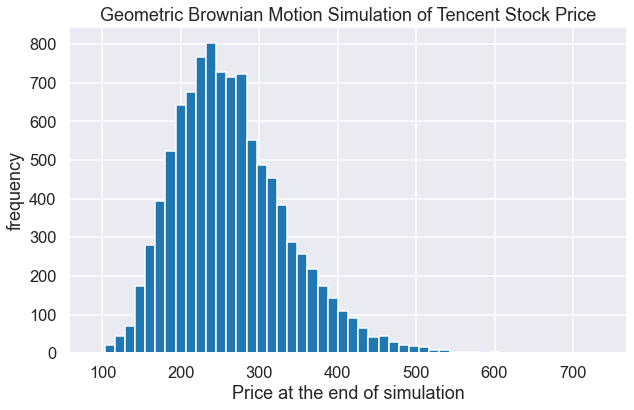

In [329]:
plt.figure(figsize=(10, 6))
plt.hist(S_gbm[-1], bins=50)
plt.title('Geometric Brownian Motion Simulation of Tencent Stock Price')
plt.xlabel('Price at the end of simulation')
plt.ylabel('frequency');

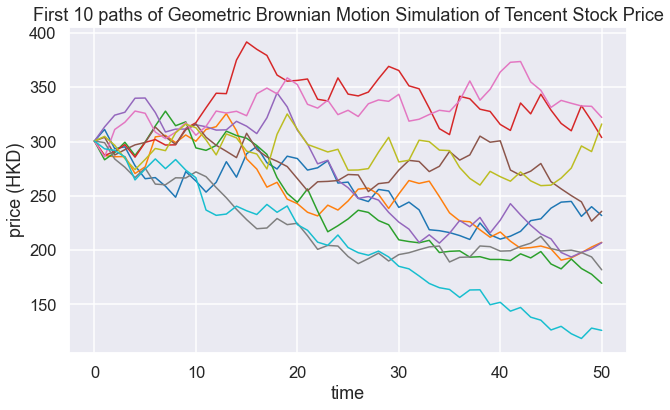

In [331]:
plt.figure(figsize=(10, 6))
plt.plot(S_gbm[:, :10], lw=1.5)
plt.title('First 10 paths of Geometric Brownian Motion Simulation of Tencent Stock Price')
plt.xlabel('time')
plt.ylabel('price (HKD)');

## VaR from geometric Brownian motion simulation

For this part, we simulate the price of Tencent stocks after 30 days for 10,000 times using GBM. Then, we calculate the change in price and sort the list by the loss. We then report the loss at different percentiles to be the VaR.

Source: Hilpisch(Page 383) 

In [14]:
Tv = 30/365
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * Tv + 
                 sigma * np.sqrt(Tv) * npr.standard_normal(I))

In [16]:
R_gbm = np.sort(ST-S0) # order the loss
R_gbm_percent = R_gbm/S0

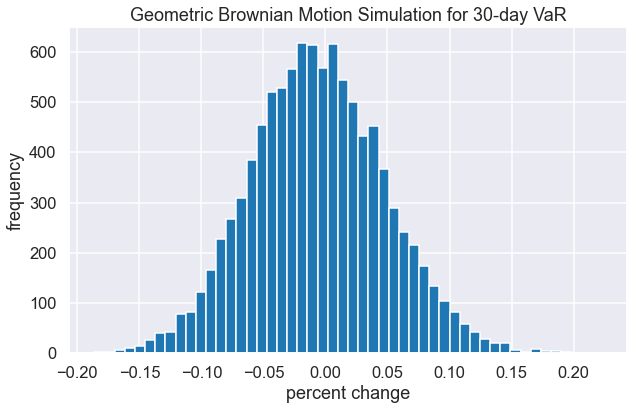

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(R_gbm_percent, bins=50)
plt.title('Geometric Brownian Motion Simulation for 30-day VaR')
plt.xlabel('percent change')
plt.ylabel('frequency');

In [18]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_gbm_percent, percs)
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99            0.179
           99.90            0.162
           99.00            0.129
           97.50            0.109
           95.00            0.092
           90.00            0.074


## Jump diffusion model

As Tencent stock price exhibits 'fat tails' and can experience sudden large movements, we can also use jump diffusion model. Furthermore, jump diffusion also accounts for volatility clustering, where periods of high volatility are followed by more high volatility. Volatility clustering is more pronounced in shorter-period interval.

$$
d S_{t} =  (r - r_{j}) S_{t}dt +  \sigma S_{t}dZ_{t} + J_{t}S_{t}dN_{t}
$$

which can discretized by an Euler scheme into the equation below

$$
S_{t} =  S_{t- \triangle t}(e^{(r - r_{j} - \frac{1}{2}  \sigma ^{2}) \bigtriangleup t + \sigma \sqrt{\triangle t} z_{t}^{1}} + (e^{\mu_{j} + \delta z_{t}^2} - 1)y_{t})    
$$

Source: McNeil, Frey, and Embrechts(Page 117 - 122), Hilpisch(Page 369)

First, we will use historical data to observe the jump intensity, the mean jump size, and the jump volatility.

In [157]:
historical_jumps = []
for x in range(len(tencent['Logreturn'])):
    cut_off = mean - (3.09 * stdev) # 
    if tencent['Logreturn'][x] < cut_off:
        historical_jumps.append(tencent['Logreturn'][x])
historical_jumps.sort()
print(historical_jumps)
print(len(tencent))

[-0.05723841086278019, -0.052694175543565196, -0.04666018527547723, -0.04473534503354843]
479


Then, we use the historical data for the jump diffusion model

In [333]:
historical_jumps_arr = np.array(historical_jumps)
lamb_j = 4 * 252 / 479 # annualized number of jumps
mu_j = historical_jumps_arr.mean() # means of the jumps that exceed the cutoff
delta_j = historical_jumps_arr.std() # std of the jumps that exceed the cutoff
rj = lamb_j * (math.exp(mu_j + 0.5 * delta_j ** 2) - 1) # the drift correction
print(lamb_j)
print(historical_jumps_arr.mean())
print(delta_j)

2.104384133611691
-0.05033202917884276
0.004951846990908276


Then, we generate three sets of random numbers: normal random sample, Poisson random sample, simulation based on exact Euler scheme. We will also run this model 10,000 times

In [366]:
S_jd = np.zeros((M + 1, I))
S_jd[0] = S0
sn1 = npr.standard_normal((M + 1, I)) # random sample from normal distribution
sn2 = npr.standard_normal((M + 1, I)) # random sample from normal distribution
poi = npr.poisson(lamb_j * dt, (M + 1, I)) # random sample from Poisson distribution
for t in range(1, M + 1, 1):
    S_jd[t] = S_jd[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * sn1[t]) + (np.exp(mu_j + delta_j * sn2[t]) - 1) * poi[t])
    S_jd[t] = np.maximum(S_jd[t], 0)

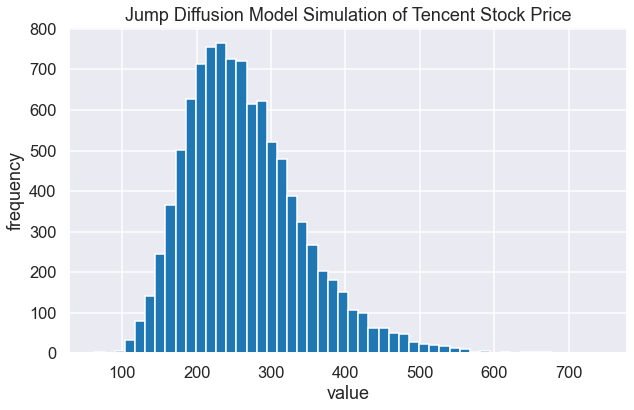

In [368]:
plt.figure(figsize=(10, 6))
plt.hist(S_jd[-1], bins=50)
plt.title('Jump Diffusion Model Simulation of Tencent Stock Price')
plt.xlabel('value')
plt.ylabel('frequency');

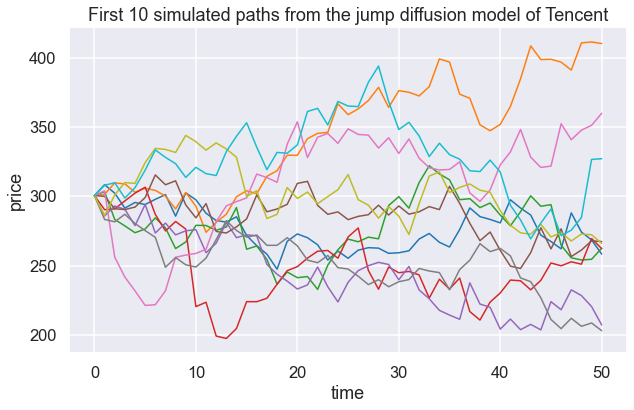

In [367]:
plt.figure(figsize=(10, 6))
plt.plot(S_jd[:, :10], lw=1.5)
plt.title('First 10 simulated paths from the jump diffusion model of Tencent')
plt.xlabel('time')
plt.ylabel('price');

## VaR from Jump Diffusion Model

For this part, we simulate the price of Tencent stocks after 30 days for 10,000 times using the Jump Diffusion Model. Then, we calculate the change in price and sort the list by the loss. We then report the loss at different percentiles to be the VaR.

Source: Hilpisch(Page 386) 

In [369]:
dt = 30. / 365 / M
S_vjd = np.zeros((M + 1, I))
S_vjd[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb_j * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S_vjd[t] = S_vjd[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
                                      + sigma * math.sqrt(dt) * sn1[t])
                               + (np.exp(mu_j + delta_j * sn2[t]) - 1)
                               * poi[t])
    S_vjd[t] = np.maximum(S_vjd[t], 0)

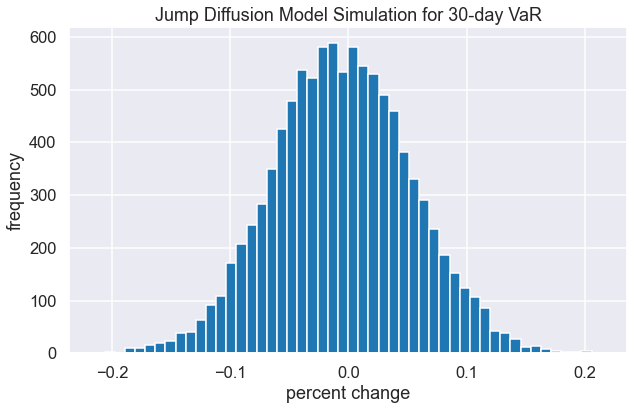

In [370]:
R_jd = np.sort(S_vjd[-1] - S0)
R_jd_percent = R_jd / S0

plt.figure(figsize=(10, 6))
plt.hist(R_jd_percent, bins=50)
plt.title('Jump Diffusion Model Simulation for 30-day VaR')
plt.xlabel('percent change')
plt.ylabel('frequency');

In [371]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_jd_percent, percs)
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99            0.204
           99.90            0.184
           99.00            0.142
           97.50            0.117
           95.00            0.099
           90.00            0.079


## VaR from GPD model

GPD model is an extension from the POT method which fit the GPD model for the excesses identified by the POT method.

For the GPD model, we would like to observe the tail behavior of Tencent's log returns. The mean excess function of the GPD is calculated as:

$$
e(u) =  \frac{ \beta +  \xi u}{1- \xi } 
$$

where u is the threshold,  $\xi$ is the shape parameter and $\beta$ is the scale parameter

First, we expand the dataset to include all the data since Tencent's IPO

Source:McNeil, Frey, and Embrechts(Page 275 - 284), Tsay(Page 362 - 366)

In [373]:
tencent=pd.read_csv('hist_price_3.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date']) #change the type of 'Date' from string to datetime processed by pd
tencent.set_index('Date',inplace=True) #set index for Date
tencent.index=tencent.index.to_period('D')

tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()
tencent['CenteredLogreturn']=tencent.apply(lambda row: row['Logreturn']-mean, axis=1)

In [374]:
tencent.head()

,Price,Previousprice,Logreturn,CenteredLogreturn
Date,,,,
2014-01-06,88.5043,88.2186,0.001404,0.001188
2014-01-07,88.2186,88.5043,-0.001404,-0.001620
2014-01-08,89.5579,88.2186,0.006544,0.006327
2014-01-09,88.0400,89.5579,-0.007424,-0.007640
2014-01-10,88.8258,88.0400,0.003859,0.003643


In [375]:
tencent.tail()

,Price,Previousprice,Logreturn,CenteredLogreturn
Date,,,,
2023-12-28,293.0,285.0,0.012023,0.011807
2023-12-29,293.6,293.0,0.000888,0.000672
2024-01-02,296.6,293.6,0.004415,0.004199
2024-01-03,300.6,296.6,0.005818,0.005602
2024-01-04,300.6,300.6,0.000000,-0.000216


First, we look for the exceesses in the data set. We experiment with the threshold level of 3%, 2%, and 1%

In [382]:
returns = tencent['Logreturn']
threshold_1 = returns.quantile(0.99)
threshold_2 = returns.quantile(0.98)
threshold_3 = returns.quantile(0.97)

excesses_1 = returns[returns > threshold_1] - threshold_1
excesses_2 = returns[returns > threshold_2] - threshold_2
excesses_3 = returns[returns > threshold_3] - threshold_3

In [383]:
c1, loc1, scale1 = scs.genpareto.fit(excesses_1)
c2, loc2, scale2 = scs.genpareto.fit(excesses_2)
c3, loc3, scale3 = scs.genpareto.fit(excesses_3)

In [384]:
print(c1, loc1, scale1)
print(c2, loc2, scale2)
print(c3, loc3, scale3)

1.3968697767163858 0.0001817083749672956 0.004692373331251318
0.24134510749415955 4.6398958585667724e-05 0.006842782550732077
0.26460462424462594 4.920831334211093e-05 0.006678169589025895


Using these parameters, we can estimate the VaR based on this VaR formula:

$$
VaR =  \beta -  \frac{ \alpha }{ \xi }  \big\{1-[-D ln(1-p)] ^{ - \xi } \big\} 
$$

Source: Tsay(Page 365)

In [385]:
VaR_1_99 = scs.genpareto.ppf(0.99, c1, loc=loc1, scale=scale1)
VaR_1_95 = scs.genpareto.ppf(0.95, c1, loc=loc1, scale=scale1)
VaR_2_99 = scs.genpareto.ppf(0.99, c2, loc=loc2, scale=scale2)
VaR_2_95 = scs.genpareto.ppf(0.95, c2, loc=loc2, scale=scale2)
VaR_3_99 = scs.genpareto.ppf(0.99, c3, loc=loc3, scale=scale3)
VaR_3_95 = scs.genpareto.ppf(0.95, c3, loc=loc3, scale=scale3)

In [386]:
print(VaR_1_99)
print(VaR_1_95)
print(VaR_2_99)
print(VaR_2_95)
print(VaR_3_99)
print(VaR_3_95)

2.086004093623273
0.21742281142400938
0.05784949809089078
0.03011773462535702
0.06017383319315218
0.03057037422714792


### Testing with the same dataset as the previous methods

While it seems that the VaR is lower for GPD which is unusual, we can consider that the tail behavior may be more poignant in the shorter time interval. Furthermore, McNeil, Frey, and Embrechts state that the tails become more i.i.d in longer time span. Thus, we attempt to find VaR with the previous dataset.

In [406]:
tencent=pd.read_csv('hist_price.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date']) #change the type of 'Date' from string to datetime processed by pd
tencent.set_index('Date',inplace=True) #set index for Date
tencent.index=tencent.index.to_period('D')

tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()
tencent['CenteredLogreturn']=tencent.apply(lambda row: row['Logreturn']-mean, axis=1)

In [407]:
tencent.head()

,Price,Previousprice,Logreturn,CenteredLogreturn
Date,,,,
2022-03-02,397.4267,404.5605,-0.007726,-0.007457
2022-03-03,393.1089,397.4267,-0.004744,-0.004475
2022-03-04,378.4659,393.1089,-0.016486,-0.016217
2022-03-07,364.1983,378.4659,-0.016689,-0.016420
2022-03-08,359.6928,364.1983,-0.005406,-0.005137


In [408]:
tencent.tail()

,Price,Previousprice,Logreturn,CenteredLogreturn
Date,,,,
2023-12-28,293.0,285.0,0.012023,0.012292
2023-12-29,293.6,293.0,0.000888,0.001158
2024-01-02,296.6,293.6,0.004415,0.004684
2024-01-03,300.6,296.6,0.005818,0.006087
2024-01-04,300.6,300.6,0.000000,0.000269


First, we look for the exceesses in the data set. We experiment with the threshold level of 3%, 2%, and 1%

In [409]:
returns = tencent['Logreturn']
threshold_1 = returns.quantile(0.99)
threshold_2 = returns.quantile(0.98)
threshold_3 = returns.quantile(0.97)


excesses_1 = returns[returns > threshold_1] - threshold_1
excesses_2 = returns[returns > threshold_2] - threshold_2
excesses_3 = returns[returns > threshold_3] - threshold_3

In [410]:
c1, loc1, scale1 = scs.genpareto.fit(excesses_1)
c2, loc2, scale2 = scs.genpareto.fit(excesses_2)
c3, loc3, scale3 = scs.genpareto.fit(excesses_3)

In [411]:
print(c1, loc1, scale1)
print(c2, loc2, scale2)
print(c3, loc3, scale3)

4.328088740858668 0.0072323010410742464 9.85614078840931e-13
1.4924867653959306 0.00025903701633562214 0.006860887492740886
0.6338527250819167 4.530386636082631e-05 0.005939178138524877


Using these parameters, we can estimate the VaR based on this VaR formula:

$$
VaR =  \beta -  \frac{ \alpha }{ \xi }  \big\{1-[-D ln(1-p)] ^{ - \xi } \big\} 
$$

Source: Tsay(Page 365)

In [412]:
VaR_1_99 = scs.genpareto.ppf(0.99, c1, loc=loc1, scale=scale1)
VaR_1_95 = scs.genpareto.ppf(0.95, c1, loc=loc1, scale=scale1)
VaR_2_99 = scs.genpareto.ppf(0.99, c2, loc=loc2, scale=scale2)
VaR_2_95 = scs.genpareto.ppf(0.95, c2, loc=loc2, scale=scale2)
VaR_3_99 = scs.genpareto.ppf(0.99, c3, loc=loc3, scale=scale3)
VaR_3_95 = scs.genpareto.ppf(0.95, c3, loc=loc3, scale=scale3)


In [413]:
print(VaR_1_99)
print(VaR_1_95)
print(VaR_2_99)
print(VaR_2_95)
print(VaR_3_99)
print(VaR_3_95)

0.00733547930650192
0.007232398401620452
4.436279317170547
0.3976748660837087
0.164232860088222
0.05325012800349139


To decide which timespan to use, I will observe the historical volatility of the Tencent stock.

In [442]:
tencent=pd.read_csv('hist_price_3.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date'])
tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()

In [443]:
tencent.head()

,Date,Price,Previousprice,Logreturn
1,2014-01-06,88.5043,88.2186,0.001404
2,2014-01-07,88.2186,88.5043,-0.001404
3,2014-01-08,89.5579,88.2186,0.006544
4,2014-01-09,88.0400,89.5579,-0.007424
5,2014-01-10,88.8258,88.0400,0.003859


In [444]:
window_size = 30
tencent['volatility'] = tencent['Logreturn'].rolling(window = window_size).std() * np.sqrt(252) #annualized the standard deviation

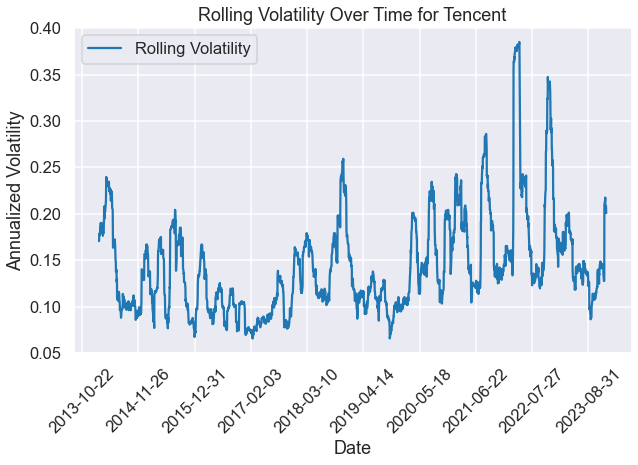

In [445]:
plt.figure(figsize=(10, 6))
plt.plot(tencent['Date'],tencent['volatility'], label='Rolling Volatility')
plt.title(f"Rolling Volatility Over Time for Tencent")
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()

locator = ticker.MaxNLocator(nbins=10)
plt.gca().xaxis.set_major_locator(locator)

plt.xticks(rotation=45)
plt.show()

## GARCH(1,1) for EVT

The following model is the adaptation of the GPD model. We follow the method in the QRM Section 7.2.6, using ARMA for VaR with GARCH errors per the following:

$$
VaR_{\alpha} ^{t} = \mu_{t+1} + \sigma_{t+1}q_{\alpha}(Z)
$$

$$
ES_{\alpha} ^{t} = \mu_{t+1} + \sigma_{t+1}ES_{\alpha}(Z)
$$

Source: McNeil, Frey, and Embrechts(Page 292)

In [449]:
from arch import arch_model

In [450]:
tencent=pd.read_csv('hist_price.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date']) #change the type of 'Date' from string to datetime processed by pd
tencent.set_index('Date',inplace=True) #set index for Date
tencent.index=tencent.index.to_period('D')

tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()
tencent['CenteredLogreturn']=tencent.apply(lambda row: row['Logreturn']-mean, axis=1)

In [451]:
garch11 = arch_model(tencent['Logreturn'], p=1, q=1)
tencent_res = garch11.fit()
print(tencent_res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 56655422.1261734
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1468.7740445746713
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1468.7740472826877
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1468.77
Distribution:                  Normal   AIC:                          -2929.55
Method:            Maximum Likelihood   BIC:                          -2912.86
                                        No. Observations:                  479
Date:                Sun, Jan 07 2024   Df Residuals:                      478
Time:         

In [452]:
tencent_forecast = tencent_res.forecast(horizon = 30)
future_vol = np.sqrt(tencent_forecast.variance.iloc[-1])

cumulative_vol = np.sqrt(np.sum(future_vol**2))

VaR_95_garch11 = scs.norm.ppf(1 - 0.95) * cumulative_vol
VaR_99_garch11 = scs.norm.ppf(1 - 0.99) * cumulative_vol

In [453]:
print(f"30-Day Value at Risk at 95% confidence level: {VaR_95_garch11}")
print(f"30-Day Value at Risk at 99% confidence level: {VaR_99_garch11}")

30-Day Value at Risk at 95% confidence level: -0.11989519820758085
30-Day Value at Risk at 99% confidence level: -0.16957006683619016


Now, we test the model with the stock price since IPO

In [454]:
tencent=pd.read_csv('hist_price_3.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date']) #change the type of 'Date' from string to datetime processed by pd
tencent.set_index('Date',inplace=True) #set index for Date
tencent.index=tencent.index.to_period('D')

tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()
tencent['CenteredLogreturn']=tencent.apply(lambda row: row['Logreturn']-mean, axis=1)

In [455]:
garch11 = arch_model(tencent['Logreturn'], p=1, q=1)
tencent_res = garch11.fit()
print(tencent_res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1849540984097352e+21
Iteration:      2,   Func. Count:     18,   Neg. LLF: -8099.974937740466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8099.974924737692
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8099.97
Distribution:                  Normal   AIC:                          -16191.9
Method:            Maximum Likelihood   BIC:                          -16168.7
                                        No. Observations:                 2462
Date:                Sun, Jan 07 2024   Df Residuals:                     2461
Time:     

In [456]:
tencent_forecast = tencent_res.forecast(horizon = 30)
future_vol = np.sqrt(tencent_forecast.variance.iloc[-1])

cumulative_vol = np.sqrt(np.sum(future_vol**2))

VaR_95_garch11 = scs.norm.ppf(1 - 0.95) * cumulative_vol
VaR_99_garch11 = scs.norm.ppf(1 - 0.99) * cumulative_vol

print(f"30-Day Value at Risk at 95% confidence level: {VaR_95_garch11}")
print(f"30-Day Value at Risk at 99% confidence level: {VaR_99_garch11}")

30-Day Value at Risk at 95% confidence level: -0.12113283690988057
30-Day Value at Risk at 99% confidence level: -0.1713204828712399


### To-do: Backtesting the 3 methods and comparison

## Backtesting

As suggested by the Basel Committee, we backtest our VaR measure at the 95% and 99% level with time horizon equal to 10 days.

Source: McNeil, Frey, and Embrechts (Page 58)

In [511]:
tencent=pd.read_csv('hist_price_3.csv')
tencent['Date']=tencent['Date'].astype(str) #change the type of 'Date'to string
tencent['Date'] = pd.to_datetime(tencent['Date']) #change the type of 'Date' from string to datetime processed by pd
tencent.set_index('Date',inplace=True) #set index for Date
tencent.index=tencent.index.to_period('D')

tencent['Previousprice']=tencent['Price'].shift(1) #Create a new column to show the price of previous day
tencent=tencent.dropna() #Remove lines with N/A, typically the first line
tencent['Logreturn']=tencent.apply(lambda row: math.log10(row['Price']/row['Previousprice']), axis=1) #Calculate the logreturn of price
mean=tencent['Logreturn'].mean()
stdev=tencent['Logreturn'].std()
tencent['CenteredLogreturn']=tencent.apply(lambda row: row['Logreturn']-mean, axis=1)
tencent['pct_change'] = (tencent['Price'] - tencent['Previousprice'])/tencent['Previousprice']

In [512]:
print(len(tencent))

2462


### GBM VaR at 95% and 99% condifence level with 10-day time horizon

In [522]:
I = 10000 # no. of paths to be simulated
M = 50 # number of time intervals
r = mean * 252 # annualized average log returns
sigma = stdev * math.sqrt(252) # annualized std dev

Tv = 10/365
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * Tv + 
                 sigma * np.sqrt(Tv) * npr.standard_normal(I))

R_gbm_back = np.sort(ST-S0)
R_gbm_back_percent = R_gbm_back/S0
back_var_95_gbm = scs.scoreatpercentile(R_gbm_back_percent, 5)
back_var_99_gbm = scs.scoreatpercentile(R_gbm_back_percent, 1)

print(f"10-Day Value at Risk for GBM at 95% confidence level: {back_var_95_gbm}")
print(f"10-Day Value at Risk for GBM at 99% confidence level: {back_var_99_gbm}")

10-Day Value at Risk for GBM at 95% confidence level: -0.040077897423482535
10-Day Value at Risk for GBM at 99% confidence level: -0.05644714958869328


### Jump Diffusion VaR at 95% and 99% confidence level with 10-day time horizon

In [523]:
dt = 10 / 365 / M
S_vjd = np.zeros((M + 1, I))
S_vjd[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb_j * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S_vjd[t] = S_vjd[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
                                      + sigma * math.sqrt(dt) * sn1[t])
                               + (np.exp(mu_j + delta_j * sn2[t]) - 1)
                               * poi[t])
    S_vjd[t] = np.maximum(S_vjd[t], 0)

R_jd_back = np.sort(S_vjd[-1] - S0)
R_jd_back_percent = R_jd_back / S0

back_var_95_jd = scs.scoreatpercentile(R_jd_back_percent, 5)
back_var_99_jd = scs.scoreatpercentile(R_jd_back_percent, 1)

print(f"10-Day Value at Risk from Jump Diffusion at 95% confidence level: {back_var_95_jd}")
print(f"10-Day Value at Risk from Jump Diffusion at 99% confidence level: {back_var_99_jd}")

10-Day Value at Risk from Jump Diffusion at 95% confidence level: -0.04528570759489528
10-Day Value at Risk from Jump Diffusion at 99% confidence level: -0.07119928268046392


### GPD Model (Threshold = 3%) VaR at 95% and 99% confidence level with 10-day time horizon

In [524]:
back_var_95_gpd = -0.0306
back_var_99_gpd = -0.0602

print(f"10-Day Value at Risk from Jump Diffusion at 95% confidence level: {back_var_95_gpd}")
print(f"10-Day Value at Risk from Jump Diffusion at 99% confidence level: {back_var_99_gpd}")

10-Day Value at Risk from Jump Diffusion at 95% confidence level: -0.0306
10-Day Value at Risk from Jump Diffusion at 99% confidence level: -0.0602


### GARCH(1,1) for EVT VaR at 95% and 99% confidence level with 10-day time horizon

In [525]:
garch11 = arch_model(tencent['Logreturn'], p=1, q=1)
tencent_res = garch11.fit()

tencent_forecast = tencent_res.forecast(horizon = 10)
future_vol = np.sqrt(tencent_forecast.variance.iloc[-1])

cumulative_vol = np.sqrt(np.sum(future_vol**2))

back_var_95_garch11 = scs.norm.ppf(1 - 0.95) * cumulative_vol
back_var_99_garch11 = scs.norm.ppf(1 - 0.99) * cumulative_vol

print(f"10-Day Value at Risk from GARCH(1,1) EVT at 95% confidence level: {back_var_95_garch11}")
print(f"10-Day Value at Risk from GARCH(1,1) EVT at 99% confidence level: {back_var_99_garch11}")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1849540984097352e+21
Iteration:      2,   Func. Count:     18,   Neg. LLF: -8099.974937740466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8099.974924737692
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
10-Day Value at Risk from GARCH(1,1) EVT at 95% confidence level: -0.07334575670308612
10-Day Value at Risk from GARCH(1,1) EVT at 99% confidence level: -0.1037343033935354


### Boolean to test for breaches

In [526]:
tencent['VaR_breach_GBM95'] = tencent['pct_change'] < back_var_95_gbm
tencent['VaR_breach_GBM99'] = tencent['pct_change'] < back_var_99_gbm
tencent['VaR_breach_JD95'] = tencent['pct_change'] < back_var_95_jd
tencent['VaR_breach_JD99'] = tencent['pct_change'] < back_var_99_jd
tencent['VaR_breach_GPD95'] = tencent['pct_change'] < back_var_95_gpd
tencent['VaR_breach_GPD99'] = tencent['pct_change'] < back_var_99_gpd
tencent['VaR_breach_GARCH95'] = tencent['pct_change'] < back_var_95_garch11
tencent['VaR_breach_GARCH99'] = tencent['pct_change'] < back_var_99_garch11

### Number of breaches

In [527]:
breaches_gbm95 = tencent['VaR_breach_GBM95'].sum()
breaches_gbm99 = tencent['VaR_breach_GBM99'].sum()
breaches_jd95 = tencent['VaR_breach_JD95'].sum()
breaches_jd99 = tencent['VaR_breach_JD99'].sum()
breaches_gpd95 = tencent['VaR_breach_GPD95'].sum()
breaches_gpd99 = tencent['VaR_breach_GPD99'].sum()
breaches_garch95 = tencent['VaR_breach_GARCH95'].sum()
breaches_garch99 = tencent['VaR_breach_GARCH99'].sum()

In [528]:
print(f'GBM95 VaR breaches: {breaches_gbm95}')
print(f'GBM99 VaR breaches: {breaches_gbm99}')
print(f'JD95 VaR breaches: {breaches_jd95}')
print(f'JD99 VaR breaches: {breaches_jd99}')
print(f'GPD95 VaR breaches: {breaches_gpd95}')
print(f'GPD99 VaR breaches: {breaches_gpd99}')
print(f'GARCH95 VaR breaches: {breaches_garch95}')
print(f'GARCH99 VaR breaches: {breaches_garch99}')

GBM95 VaR breaches: 73
GBM99 VaR breaches: 22
JD95 VaR breaches: 50
JD99 VaR breaches: 8
GPD95 VaR breaches: 154
GPD99 VaR breaches: 19
GARCH95 VaR breaches: 8
GARCH99 VaR breaches: 2


### Average magnitude of breaches

In [529]:
avg_magnitude_gbm95 = tencent[tencent['VaR_breach_GBM95']]['pct_change'].mean()
avg_magnitude_gbm99 = tencent[tencent['VaR_breach_GBM99']]['pct_change'].mean()
avg_magnitude_jd95 = tencent[tencent['VaR_breach_JD95']]['pct_change'].mean()
avg_magnitude_jd99 = tencent[tencent['VaR_breach_JD99']]['pct_change'].mean()
avg_magnitude_gpd95 = tencent[tencent['VaR_breach_GPD95']]['pct_change'].mean()
avg_magnitude_gpd99 = tencent[tencent['VaR_breach_GPD99']]['pct_change'].mean()
avg_magnitude_garch95 = tencent[tencent['VaR_breach_GARCH95']]['pct_change'].mean()
avg_magnitude_garch99 = tencent[tencent['VaR_breach_GARCH99']]['pct_change'].mean()

In [530]:
print(f'Average magnitude of breaches (GBM95): {avg_magnitude_gbm95}')
print(f'Average magnitude of breaches (GBM99): {avg_magnitude_gbm99}')
print(f'Average magnitude of breaches (JD95): {avg_magnitude_jd95}')
print(f'Average magnitude of breaches (JD99): {avg_magnitude_jd99}')
print(f'Average magnitude of breaches (GPD95): {avg_magnitude_gpd95}')
print(f'Average magnitude of breaches (GPD99): {avg_magnitude_gpd99}')
print(f'Average magnitude of breaches (GARCH(1,1) 95): {avg_magnitude_garch95}')
print(f'Average magnitude of breaches (GARCH(1,1) 99): {avg_magnitude_garch99}')

Average magnitude of breaches (GBM95): -0.05528443581301339
Average magnitude of breaches (GBM99): -0.07544429343813928
Average magnitude of breaches (JD95): -0.061154979190815896
Average magnitude of breaches (JD99): -0.09541130501791589
Average magnitude of breaches (GPD95): -0.04441658826059024
Average magnitude of breaches (GPD99): -0.07809590647760652
Average magnitude of breaches (GARCH(1,1) 95): -0.09541130501791589
Average magnitude of breaches (GARCH(1,1) 99): -0.11887068507373105
